In [1]:
import pandas as pd
from transformers import pipeline
from collections import Counter
import spacy
import torch
import re

In [2]:
device_id = 0 if torch.cuda.is_available() else -1 
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple", device=device_id)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
CONTEXT_LABELS = ["enemy", "partner", "ally", "neighbour"]

In [4]:
nlp = spacy.load("en_core_web_sm")

In [30]:
COUNTRY_MAP = {
    "Russian Federation": "Russia",
    "Soviet Union": "Russia",
    "French": "France",
    "French Republic": "France",
    "U.S.": "USA",
    "United States": "USA",
    "America": "USA",
    "Ukrainian": "Ukraine",
    "Polish": "Poland"
}

In [6]:
df = pd.read_csv('data/putins_talks_prepared.csv')
df_poc = df.sample(frac=0.05, random_state=42).copy() # Samples 5% of the data
print(f"Limiting analysis to 5% of the records ({len(df_poc)} rows).")
df_poc['date'] = pd.to_datetime(df['date'])
df_poc['date_str'] = df_poc['date'].dt.strftime('%Y-%m-%d')

Limiting analysis to 5% of the records (254 rows).


In [44]:
df_poc

,date,persons,transcript_unfiltered,kremlin_id,place,title,teaser,tags,transcript_filtered,wordlist,grouped_tages,date_str,extracted_countries
2298,2016-12-23 11:40:00,[],"President of Russia Vladimir Putin: Mr Shoigu,...",53575.0,"The Kremlin, Moscow",Working meeting with Defence Minister Sergei S...,Vladimir Putin had a working meeting with Defe...,['Foreign policy'],"Mr Shoigu, I know that the operation to libera...","['Mr', 'Shoigu', ',', 'I', 'know', 'that', 'th...",['International_Relations_Global_Organizations'],2016-12-23,[]
3770,2019-09-17 17:45:00,[],"President of Russia Vladimir Putin: Hello, col...",61548.0,Moscow,Meeting on flood relief operations in the Far ...,Vladimir Putin held a meeting at the Emergenci...,['Regions'],"Hello, colleagues, This year we have more than...","['hello', ',', 'colleague', ',', 'this', 'year...",['State_Governance_Public_Service'],2019-09-17,[]
33,2012-05-25 20:30:00,[],* * * President of Russia Vladimir Putin: Good...,15440.0,"Barvikha, Moscow Region",Informal meeting with the leadership of the Pr...,Vladimir Putin held an informal meeting with t...,['Civil service'],"Good evening, colleagues, Mr Medvedev and I ha...","['good', 'evening', ',', 'colleague', ',', 'Mr...",['State_Governance_Public_Service'],2012-05-25,"[Russia, Russia]"
1244,2014-11-07 19:20:00,[],President of Russia Vladimir Putin: Ladies and...,46976.0,"Novo-Ogaryovo, Moscow Region",Press statement following talks with President...,NaN,['Foreign policy'],"Ladies and gentlemen, This visit by the Peruvi...","['lady', 'and', 'gentleman', ',', 'this', 'vis...",['International_Relations_Global_Organizations'],2014-11-07,"[Russia, Peru, Peru, Peru, Peru, Peru]"
3049,2018-05-23 19:10:00,[],"President of Russia Vladimir Putin: Mr Titov, ...",57532.0,St Petersburg,Meeting with Commissioner for Entrepreneurs’ R...,Commissioner for Entrepreneurs’ Rights Boris T...,['Support for business'],"Mr Titov, you have the annual report. Presiden...","['Mr', 'Titov', ',', 'you', 'have', 'the', 'an...",['Business_Special_Development'],2018-05-23,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,2015-03-13 12:30:00,[],President of Russia Vladimir Putin: Mr Lebedev...,47847.0,"Novo-Ogaryovo, Moscow Region",Meeting with President of the Supreme Court Vy...,Vladimir Putin met with President of the Supre...,['Court'],"Mr Lebedev, you have probably had time to gath...","['Mr', 'Lebedev', ',', 'you', 'have', 'probabl...",['Justice_Anti-Corruption_Rights'],2015-03-13,[]
88,2012-06-21 20:45:00,[],* * * President of Russia Vladimir Putin: Good...,15716.0,St Petersburg,Meeting with heads of energy companies,Vladimir Putin met with heads of major interna...,['Energy'],"Good afternoon, ladies and gentlemen, Thank yo...","['good', 'afternoon', ',', 'lady', 'and', 'gen...",['Natural_Resources_Primary_Industries_Environ...,2012-06-21,"[Russia, Russia, Russia, Russia]"
4329,2021-02-04 11:00:00,[],President of Russia Vladimir Putin: Mr Reshetn...,64965.0,"The Kremlin, Moscow",Working meeting with Minister of Economic Deve...,"The discussion covered, in particular, the sit...","['Agriculture', 'Economy and finance']","Mr Reshetnikov, we have discussed monitoring t...","['Mr', 'Reshetnikov', ',', 'we', 'have', 'disc...",['Natural_Resources_Primary_Industries_Environ...,2021-02-04,"[Russia, Russia]"
2323,2017-01-18 13:45:00,[],The Bovanenkovo oil and gas condensate field d...,53745.0,"The Kremlin, Moscow",Launch of Bovanenkovo-Ukhta 2 gas pipeline and...,Vladimir Putin via videoconference launched th...,['Energy'],"Good afternoon, friends. We have a good day to...","['good', 'afternoon', ',', 'friend', '.', ' ',...",['Natural_Resources_Primary_Industries_Environ...,2017-01-18,"[Russia, Russia]"


In [8]:
import pycountry
CANONICAL_COUNTRIES = set([country.name for country in pycountry.countries] + 
                          [country.official_name for country in pycountry.countries if hasattr(country, 'official_name')] +
                          ['Russia', 'Soviet Union', 'Eurasia']) # Added common aliases/regions

In [45]:
def chunk_text(text: str, max_words: int = 450, overlap: int = 50) -> list[str]:
    """Splits text into overlapping chunks safe for BERT's 512-token limit."""
    words = text.split()
    chunks = []
    start_word_index = 0
    total_words = len(words)
    
    while start_word_index < total_words:
        end_word_index = min(start_word_index + max_words, total_words)
        chunk_text = " ".join(words[start_word_index:end_word_index])
        chunks.append(chunk_text)
        
        start_word_index += max(1, max_words - overlap)
        
    return chunks

In [46]:
def aggregate_and_normalize_entities(raw_chunk_results, doc_start, doc_end, canonical_countries):
    """
    Applies filtering and normalization across multiple chunks belonging to one document.
    """
    # Slice the results specific to one document
    document_chunk_results = raw_chunk_results[doc_start:doc_end]
    
    countries = set() # Use a set to handle de-duplication from overlaps
    
    for chunk_entities in document_chunk_results:
        for entity in chunk_entities:
            if entity['entity_group'] in ['GPE', 'LOC']:
                name = entity['word'].strip()
                
                # Apply normalization/aliasing (e.g., "Russian Federation" -> "Russia")
                normalized_name = COUNTRY_MAP.get(name, name)
                
                # Final Filter: Only keep normalized names that exist in the canonical list
                if normalized_name in canonical_countries:
                    countries.add(normalized_name) # Add to the set
                    
    return list(countries)

In [48]:
all_chunks = []
doc_map = [] # Maps NER results back to the original document index

for index, text in enumerate(df_poc['transcript_filtered'].tolist()):
    chunks = chunk_text(text)
    all_chunks.extend(chunks)
    # Store where the results for this document start and end in the all_chunks list
    doc_map.append({'start': len(all_chunks) - len(chunks), 'end': len(all_chunks)})
    
raw_chunk_results = ner_pipeline(all_chunks, batch_size=32)

final_country_lists = []
for i, map_info in enumerate(doc_map):
    countries_found = aggregate_and_normalize_entities(
        raw_chunk_results, 
        map_info['start'], 
        map_info['end'],
        CANONICAL_COUNTRIES
    )
    final_country_lists.append(countries_found)
df_poc['extracted_countries'] = final_country_lists

In [68]:
# Save df with extracted countries
df_poc.to_csv('data/putins_talks_with_countries.csv', 
          encoding='utf-8', 
          index=False)

In [49]:
# Q1: How many times do "Poland" and "Ukraine" appear?
all_countries = [country for sublist in df_poc['extracted_countries'] for country in sublist]
counts = Counter(all_countries)

print(f"Poland count: {counts.get('Poland', 0)}")
print(f"Ukraine count: {counts.get('Ukraine', 0)}")

Poland count: 5
Ukraine count: 23


In [50]:
# Q2: Which country, apart from Russia, appears most frequently?
non_russia_counts = {k: v for k, v in counts.items() if k != 'Russia'}
if non_russia_counts:
    most_freq_country = max(non_russia_counts, key=non_russia_counts.get)
    print(f"Most frequent non-Russia country: {most_freq_country} ({non_russia_counts[most_freq_country]})")

Most frequent non-Russia country: China (24)


In [51]:
# Q3: List all countries mentioned in speech from date Y
target_date = "2016-04-11"
countries_on_date = df_poc[df_poc['date_str'] == target_date]['extracted_countries'].sum()
print(f"Countries on {target_date}: {set(countries_on_date)}")

Countries on 2016-04-11: {'China', 'Germany', 'Russia'}


In [52]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [53]:
def get_accompanying_terms(text, aliases):
    """
    Uses spaCy dependency parsing to find adjectives, compounds, and appositional
    modifiers for any token matching the target entity aliases.
    """
    doc = nlp(text)
    accompanying_terms = []
    
    # Define dependency types that provide descriptive context
    DESCRIPTIVE_DEPS = ["amod", "compound", "appos", "poss"]

    for token in doc:
        # Check if the token or its lemma matches any of the target aliases
        if token.text in aliases or token.lemma_ in aliases:
            # Check the token's children for descriptive dependencies
            for child in token.children:
                if child.dep_ in DESCRIPTIVE_DEPS:
                    # Capture the term and normalize it
                    term = child.text.lower().replace("'", "").strip()
                    if term:
                        accompanying_terms.append(term)
    
    return accompanying_terms

transcripts = df_poc['transcript_filtered'].tolist()

In [66]:
# Q4: What adjectives or terms most often accompany the word “Ukraine”
def show_terms_accompanied_with_word(TARGET_ENTITY, TARGET_ALIASES):
    all_terms = []
    for text in transcripts:
        terms = get_accompanying_terms(text, TARGET_ALIASES)
        all_terms.extend(terms)
    terms_counts = Counter(all_terms)
    print(f"Top accompanying terms for '{TARGET_ENTITY}':")
    # Output the top 5 most common adjectives
    for term, count in terms_counts.most_common(5):
        print(f"-> {term.capitalize()}: {count} times")
        
show_terms_accompanied_with_word("Ukraine", {"Ukraine", "Ukrainian", "Kiev", "Kyiv"})

Top accompanying terms for 'Ukraine':
-> Southeast: 3 times
-> Eastern: 2 times
-> Soviet: 1 times
-> Western: 1 times


In [67]:
show_terms_accompanied_with_word("China", {"China", "Chinese"})

Top accompanying terms for 'China':
-> Russian: 14 times
-> New: 2 times
-> Western: 1 times
-> Russia: 1 times
-> India: 1 times


In [55]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

labels = ["enemy", "partner", "ally", "neighbor"]

'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 2b9ca71d-c7f8-47b3-9b8e-531ad8b55911)')' thrown while requesting HEAD https://huggingface.co/facebook/bart-large-mnli/resolve/main/config.json
Retrying in 1s [Retry 1/5].


In [57]:
def classify_context(text, target_word):
    # Extract sentences containing the target word first to reduce noise
    sentences = text.split('.')
    target_sentences = [s for s in sentences if target_word in s]
    
    if not target_sentences:
        return None
    # Classify the specific sentence
    results = classifier(target_sentences[0], labels)
    return results['labels'][0] # Returns the highest probability label

In [62]:
# Q5: In what context does “Poland” most often appear? (enemy, partner, ally, neighbour) 
def show_context_of_word(TARGET_WORD):
    all_contexts = []
    for index, row in df_poc.iterrows():
        text = row['transcript_filtered']    
        context = classify_context(text, TARGET_WORD)    
        if context:
            all_contexts.append(context)
    context_counts = Counter(all_contexts)
    most_often = context_counts.most_common(1)[0]
    print(f"'{TARGET_WORD}' Most Often Appears As: {most_often[0].capitalize()} ({most_often[1]} time(s))")
    print("\nFull Context Breakdown:")
    print(pd.Series(context_counts))
show_context_of_word("Poland")

'Poland' Most Often Appears As: Partner (3 time(s))

Full Context Breakdown:
partner     3
neighbor    2
dtype: int64


In [63]:
show_context_of_word("Ukraine")

'Ukraine' Most Often Appears As: Partner (14 time(s))

Full Context Breakdown:
partner     14
enemy        5
neighbor     3
ally         1
dtype: int64


In [64]:
show_context_of_word("China")

'China' Most Often Appears As: Partner (17 time(s))

Full Context Breakdown:
partner     17
neighbor     3
ally         4
enemy        1
dtype: int64


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

In [74]:
all_countries = df_poc['extracted_countries'].explode().dropna()
country_counts = all_countries[all_countries != 'Russia'].value_counts()
top_countries = country_counts.head(5).index.tolist()

In [72]:
print(f"Top 5 Countries for detailed analysis: {top_countries}")

Top 5 Countries for detailed analysis: ['China', 'Ukraine', 'France', 'Japan', 'Germany']


In [75]:
top_countries.append("Poland")

/tmp/ipykernel_14474/1780457223.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15, x="Mentions", y="Country", palette="viridis")


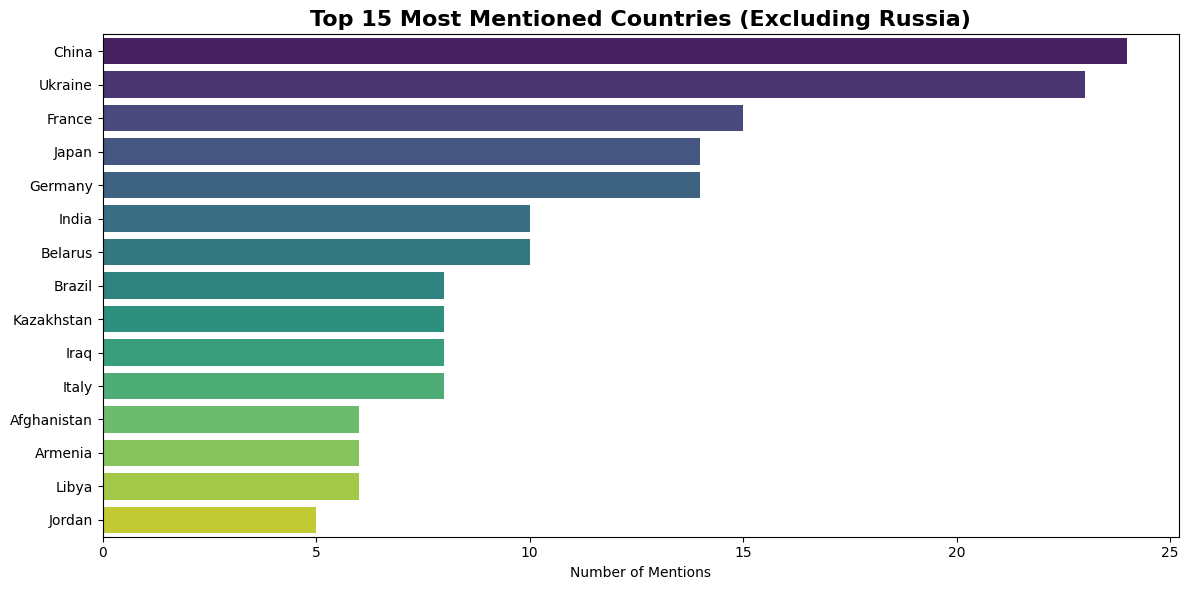

In [76]:
def plot_country_counts():
    plt.figure(figsize=(12, 6))
    # Get top 15 for readability
    top_15 = country_counts.head(15).reset_index()
    top_15.columns = ['Country', 'Mentions']
    
    sns.barplot(data=top_15, x="Mentions", y="Country", palette="viridis")
    plt.title('Top 15 Most Mentioned Countries (Excluding Russia)', fontsize=16, fontweight='bold')
    plt.xlabel('Number of Mentions')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()
plot_country_counts()

/tmp/ipykernel_14474/843276052.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  timeline = df_time.groupby(['extracted_countries', pd.Grouper(key='date', freq='Y')]).size().reset_index(name='Counts')


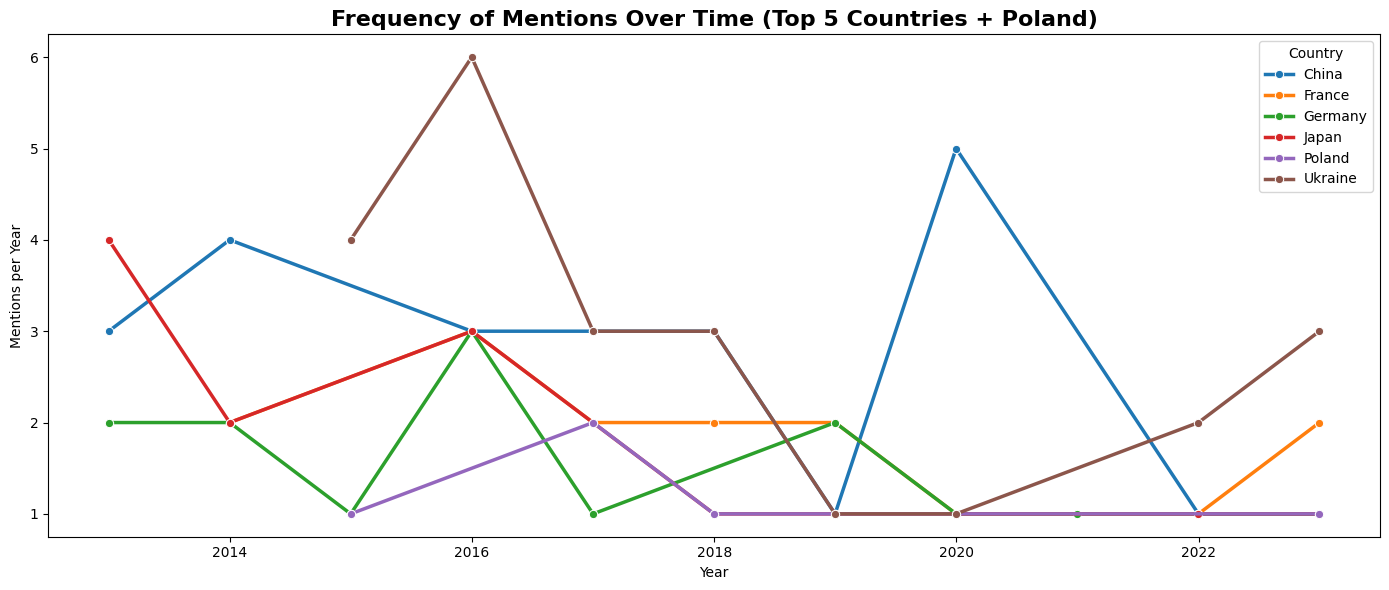

In [78]:
def plot_mentions_over_time():
    # Prepare data: Explode countries and group by date
    df_exploded = df_poc.explode('extracted_countries')
    
    # Filter for only our top 5 countries
    df_time = df_exploded[df_exploded['extracted_countries'].isin(top_countries)].copy()
    
    # Group by Year (or Month 'M') and Country
    # Using 'Y' for smoother lines over a long period, switch to 'M' for granularity
    timeline = df_time.groupby(['extracted_countries', pd.Grouper(key='date', freq='Y')]).size().reset_index(name='Counts')
    
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=timeline, x="date", y="Counts", hue="extracted_countries", marker="o", linewidth=2.5)
    
    plt.title('Frequency of Mentions Over Time (Top 5 Countries + Poland)', fontsize=16, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Mentions per Year')
    plt.legend(title='Country')
    plt.tight_layout()
    plt.show()
plot_mentions_over_time()

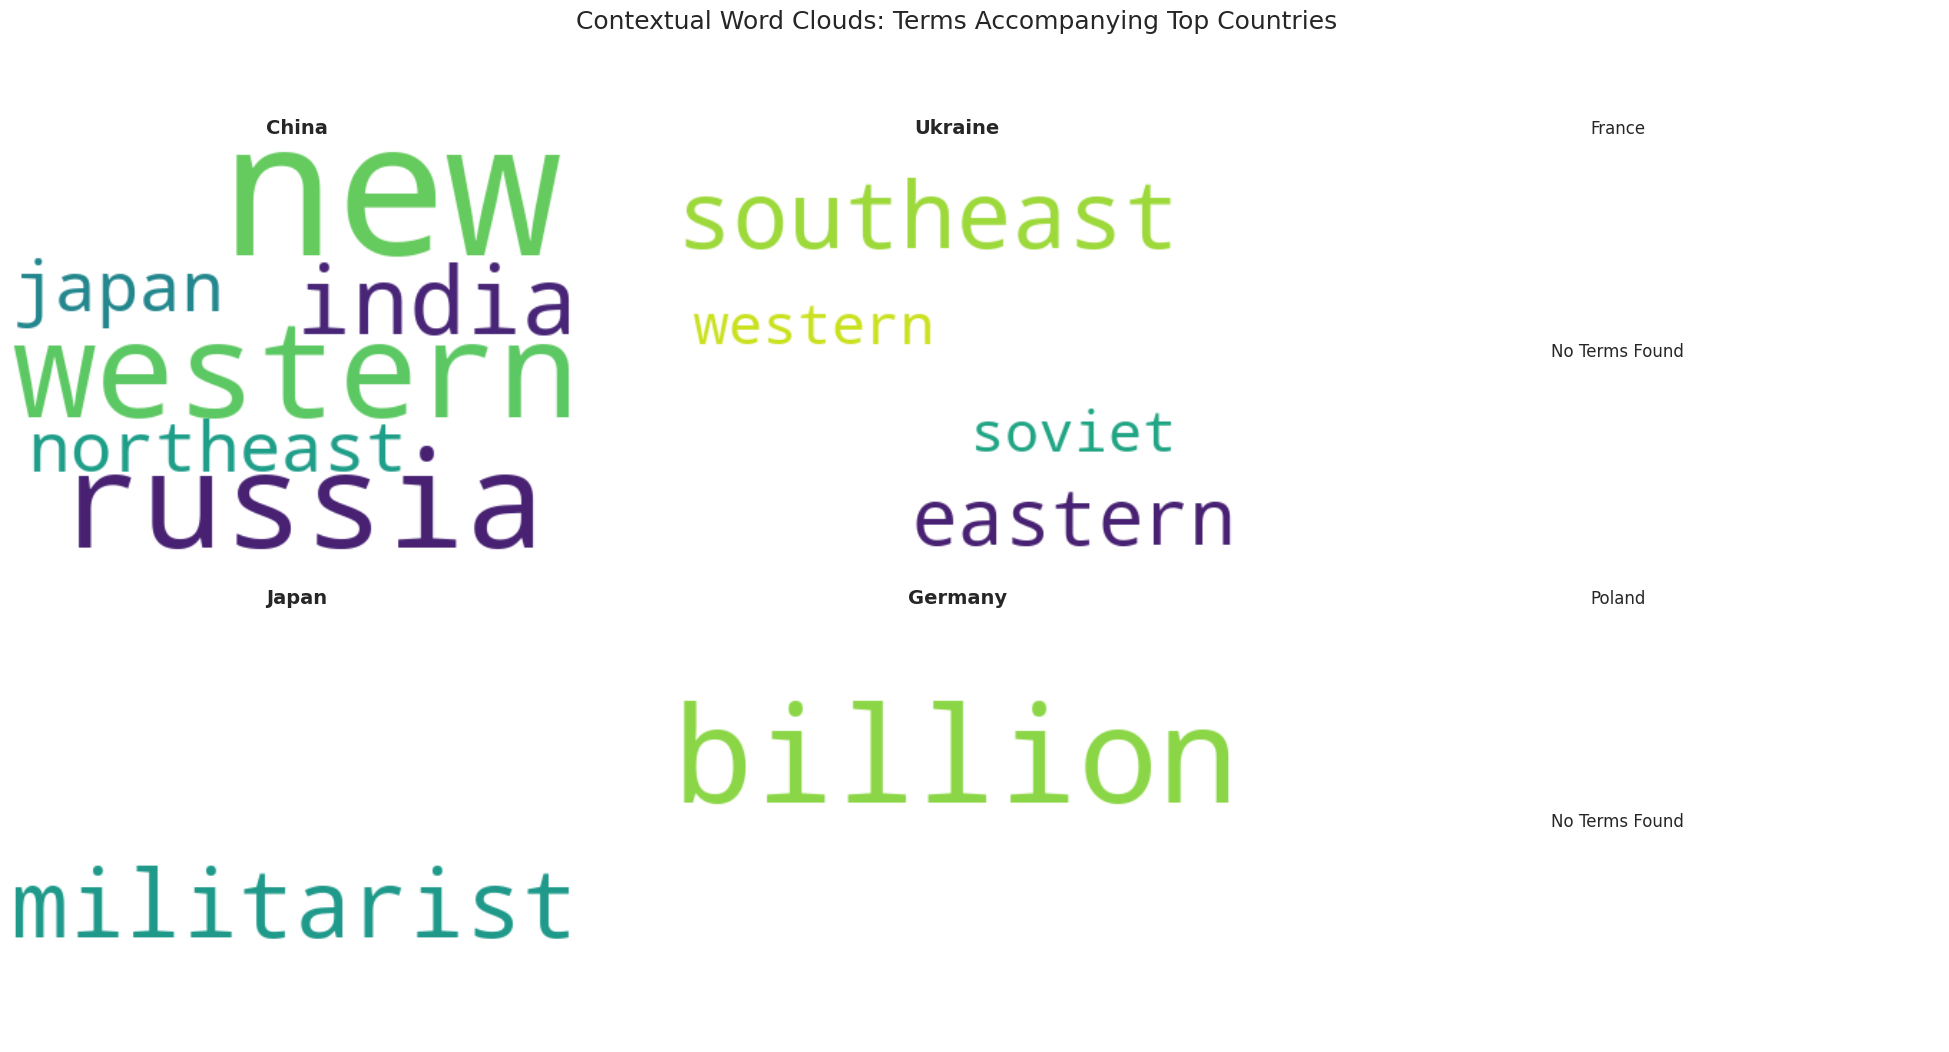

In [86]:
def plot_word_clouds():
    # Helper to collect terms for a specific country using your existing logic
    # (Assuming get_accompanying_terms and nlp are defined from previous steps)
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    axes = axes.flatten()
    
    for i, country in enumerate(top_countries):
        all_terms = []
        # Filter transcripts containing the country
        # Note: This is a rough filter; ideally we check if the entity is in the specific row
        relevant_rows = df_poc[df_poc['extracted_countries'].apply(lambda x: country in x if isinstance(x, list) else False)]
        
        for text in relevant_rows['transcript_filtered']:
            # We use the country name as the alias for simplicity in this loop
            terms = get_accompanying_terms(text, {country, country.lower()}) 
            all_terms.extend(terms)
        
        if all_terms:
            text_cloud = " ".join(all_terms)
            wc = WordCloud(width=400, height=300, background_color='white', colormap='viridis').generate(text_cloud)
            axes[i].imshow(wc, interpolation='bilinear')
            axes[i].set_title(country, fontsize=14, fontweight='bold')
        else:
            axes[i].text(0.5, 0.5, "No Terms Found", ha='center')
            axes[i].set_title(country)
            
        axes[i].axis('off')
    
    plt.suptitle(f'Contextual Word Clouds: Terms Accompanying Top Countries', fontsize=18, y=1.05)
    plt.tight_layout()
    plt.show()
plot_word_clouds()

Calculating diplomatic framing (this may take a moment)...


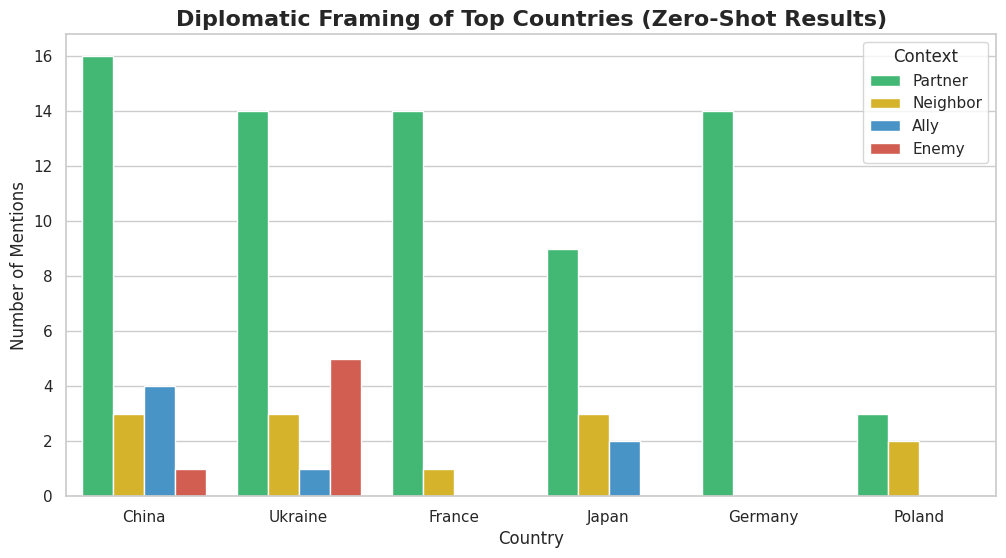

In [83]:
def plot_diplomatic_framing():
    framing_data = []
    
    # Calculate context only for top 5 to save time
    print("Calculating diplomatic framing (this may take a moment)...")
    for country in top_countries:
        relevant_rows = df_poc[df_poc['extracted_countries'].apply(lambda x: country in x if isinstance(x, list) else False)]
        
        contexts = []
        for text in relevant_rows['transcript_filtered']:
            # Reuse your existing classify_context function
            label = classify_context(text, country)
            if label:
                contexts.append(label)
        
        # Count labels
        counts = Counter(contexts)
        for label, count in counts.items():
            framing_data.append({'Country': country, 'Context': label.capitalize(), 'Count': count})
            
    df_framing = pd.DataFrame(framing_data)
    
    if not df_framing.empty:
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=df_framing, 
            x="Country", 
            y="Count", 
            hue="Context", 
            palette={"Partner": "#2ecc71", "Ally": "#3498db", "Neighbor": "#f1c40f", "Enemy": "#e74c3c"}
        )
        plt.title('Diplomatic Framing of Top Countries (Zero-Shot Results)', fontsize=16, fontweight='bold')
        plt.ylabel('Number of Mentions')
        plt.show()
    else:
        print("No context data found.")
plot_diplomatic_framing()